In [ ]:
!pip install --upgrade emoji
!pip install emoji-data-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.9/358.9 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.8/105.8 kB 956.3 kB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import plotly.express as px

import re
import regex
import emoji
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
from emoji_data_python import emoji_short_names

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Funciones necesarias

In [ ]:
def fecha_hora(s):
    # Patrón para validar el formato de fecha DD/MM/AA HH:MM a. m./p. m.
    patron = '^(0[1-9]|[1-9]|1[0-9]|2[0-9]|3[0-1])\/(0[1-9]|1[0-2])\/(2[0-9]) (1[0-2]|[1-9]):([0-5][0-9])'
    resultado = re.match(patron, s)

    if resultado:
        return True
    return False

# Patron para encontrar a los miembros del grupo dentro del txt
def EncontrarMiembro(s):
    patrones = [
        '([\w\s.]+):',                                    # Nombre
        '([\w]+[\s]+[\(]+[\w]+[\)]+):',      # Nombre (Apodo)
        '([\w]+[\s]+[\w]+):',                    # Nombre + Apellido
        '([\w]+[\s]+[\w]+[\s]+[\w]+):',    # Nombre 1 + Nombre 2 + Apellido
        '([+]\d{2} \d{3} \d{3} \d{4}):',     # Número de teléfono (Mex)
        '([+]\d{2} \d{2} \d{4} \d{4}):',     # Número de teléfono (Mex)
        '([\w]+)[\u263a-\U0001f999]+:', # Nombre + Emoji
    ]
    patron = '^' + '|'.join(patrones)
    resultado = re.findall(patron, s)  # Verificar si cada línea del txt hace match con el patrón de miembro
    if resultado:
        return True
    return False

# Separar las partes de cada línea del txt: Fecha, Hora, Miembro y Mensaje
def ObtenerPartes(linea):
    # Ejemplo: '21/2/2021 11:27 a. m. - Sandro: Todos debemos aprender a analizar datos'
    splitLinea = linea.split(' - ')
    FechaHora = splitLinea[0]                     # '21/2/2021 11:27 a. m.'
    splitFechaHora = FechaHora.split(' ')
    Fecha = splitFechaHora[0]                    # '21/2/2021'
    Hora = ' '.join(splitFechaHora[1:])          # '11:27 a. m.'
    Mensaje = ' '.join(splitLinea[1:])             # 'Sandro: Todos debemos aprender a analizar datos'
    if EncontrarMiembro(Mensaje):
        splitMensaje = Mensaje.split(': ')
        Miembro = splitMensaje[0]               # 'Sandro'
        Mensaje = ' '.join(splitMensaje[1:])    # 'Todos debemos aprender a analizar datos'
    else:
        Miembro = None
    return Fecha, Hora, Miembro, Mensaje

#Obtener el Data Frame


In [ ]:
# Leer el archivo txt descargado del chat de WhatsApp
RutaChat = '/content/drive/MyDrive/Colab Notebooks/Actividad/data/Chat de WhatsApp con Chems del 9A.txt'
con = 0

# Lista para almacenar los datos (Fecha, Hora, Miembro, Mensaje) de cada línea del txt
DatosLista = []
with open(RutaChat, encoding="utf-8") as fp:
    fp.readline() # Eliminar primera fila relacionada al cifrado de extremo a extremo
    VerificarMensaje = [] # Lista para verificar que no existan mensajes vacíos
    Fecha, Hora, Miembro = None, None, None
    while True:
        linea = fp.readline()

        if not linea:
            break
        linea = linea.strip()

        if fecha_hora(linea): # Si cada línea del txt coincide con el patrón fecha y hora

            if len(VerificarMensaje) > 0:
              # Añadir un elemento lista que contendrá los datos a la lista 'DatosLista'
              DatosLista.append([Fecha, Hora, Miembro, ' '.join(VerificarMensaje)])

            VerificarMensaje.clear()
            Fecha, Hora, Miembro, Mensaje = ObtenerPartes(linea) # Obtener datos de cada línea del txt
            VerificarMensaje.append(Mensaje)
        else:
            VerificarMensaje.append(linea)


# Convertir la lista con los datos a dataframe
df = pd.DataFrame(DatosLista, columns=['Fecha', 'Hora', 'Miembro', 'Mensaje'])

# Cambiar la columna Fecha a formato datetime
df['Fecha'] = pd.to_datetime(df['Fecha'], format="%d/%m/%y")

# Eliminar los posibles campos vacíos del dataframe
# y lo que no son mensajes como cambiar el asunto del grupo o agregar a alguien
df = df.dropna()

# Rester el índice
df.reset_index(drop=True, inplace=True)
#DatosLista
#VerificarMensaje


In [ ]:
def ObtenerEmojis(Mensaje):
    emoji_lista = []
    data = regex.findall(r'\X', Mensaje) # Obtener lista de caracteres de cada mensaje
    for caracter in data:
        if any(c in emoji.EMOJI_DATA for c in caracter): # Obtener emojis en idioma español: 'es'
            emoji_lista.append(caracter)
    return emoji_lista

#Obtener el total de mensajes
total_msg = df.shape[0]

#Obtener el total de multimedia
total_media = df[df['Mensaje']=='<Multimedia omitido>'].shape[0]

#obtener emojis enviados
df['Emojis'] = df['Mensaje'].apply(ObtenerEmojis)
total_emojis = df['Emojis'].apply(len).sum()

#link enviados
url_patron = r'(https?://\S+)'
df['URLs'] = df['Mensaje'].apply(lambda x: re.findall(url_patron,x)).apply(len)
total_urls = np.sum(df.URLs)
#df[500:]
total_urls

estadistica = {
    'Tipo':[
        'Mensajes',
        'Multimedia',
        'Links',
        'Emojis'
      ],
    'Total':[
        total_msg,
        total_media,
        total_urls,
        total_emojis
    ]
}

df_estadistica = pd.DataFrame(estadistica,columns=['Tipo','Total'])
df_estadistica.set_index('Tipo')




,Total
Tipo,
Mensajes,9446
Multimedia,1829
Links,313
Emojis,398


In [ ]:
#Obtener una muestra aleatorea
df.sample(15)

,Fecha,Hora,Miembro,Mensaje,Emojis,URLs
4647,2022-01-03,11:19 a. m.,+52 55 4386 1758,Nenis 3.0,[],0
8296,2023-01-26,2:20 p. m.,+52 227 103 4148,Jimon,[],0
2601,2021-10-28,12:16 p. m.,+52 227 116 8167,Ya se,[],0
6321,2022-02-08,10:18 a. m.,Mauricio,Todavía? Jajajaja,[],0
2582,2021-10-27,10:59 p. m.,Lilibet,Uriel lo va mandando en cuanto tengan su firma...,[],0
5680,2022-01-26,10:36 p. m.,+52 227 103 4148,chimon,[],0
9358,2023-10-10,5:08 p. m.,Chema,Luna ya está en el lab,[],0
1240,2021-09-27,2:02 p. m.,+52 55 4386 1758,<Multimedia omitido>,[],0
5283,2022-01-25,10:33 a. m.,+52 248 185 4098,chimon ta izi,[],0
738,2021-09-17,11:06 a. m.,+52 55 4386 1758,Nada?,[],0


#Emojis mas utilizados

In [ ]:
emojis_lista = list([a for b in df.Emojis for a in b])
emoji_diccionario = dict(Counter(emojis_lista))
emoji_diccionario = sorted(emoji_diccionario.items(), key=lambda x: x[1], reverse=True)

# Convertir el diccionario a dataframe
emoji_df = pd.DataFrame(emoji_diccionario, columns=['Emoji', 'Cantidad'])

# Establecer la columna Emoji como índice
emoji_df = emoji_df.set_index('Emoji')

print('Cantidad de emojis usados: ', len(emoji_df), '\n')
emoji_df[:10]

Cantidad de emojis usados:  96 



,Cantidad
Emoji,
🤣,90
😂,41
👀,27
🤭,17
🥲,13
🙄,12
😬,12
🥺,8
😅,7


In [ ]:
# Plotear el pie de los emojis más usados
fig = px.pie(emoji_df, values='Cantidad', names=emoji_df.index, title='Gráfica de emojis')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()


In [ ]:
# Identificar a todos los miembros del grupo
df.Miembro.unique()

In [ ]:
# Determinar los miembros más activos del grupo
df_MiembrosActivos = df.groupby('Miembro')['Mensaje'].count().sort_values(ascending=False).to_frame()
df_MiembrosActivos.reset_index(inplace=True)
df_MiembrosActivos.index = np.arange(1, len(df_MiembrosActivos)+1)
df_MiembrosActivos.head(5)

,Miembro,Mensaje
1,+52 55 4386 1758,1861
2,+52 227 116 8167,1657
3,Chema,1075
4,+52 227 103 4148,801
5,+52 248 185 4098,587


In [ ]:
# Separar mensajes (sin multimedia) y multimedia (stickers, fotos, videos)
multimedia_df = df[df['Mensaje'] == '<Multimedia omitido>']
mensajes_df = df.drop(multimedia_df.index)

# Contar la cantidad de palabras y letras por mensaje
mensajes_df['Letras'] = mensajes_df['Mensaje'].apply(lambda s : len(s))
mensajes_df['Palabras'] = mensajes_df['Mensaje'].apply(lambda s : len(s.split(' ')))
mensajes_df.tail()

,Fecha,Hora,Miembro,Mensaje,Emojis,URLs,Letras,Palabras
9441,2023-11-09,5:40 p. m.,Chema,https://docs.google.com/forms/d/e/1FAIpQLSejaX...,[],1,111,1
9442,2023-11-09,5:40 p. m.,Chema,"Les mando la liga del examen de la plataforma,...",[],0,92,18
9443,2023-11-09,5:40 p. m.,Chema,No llegaré a clase,[],0,18,4
9444,2023-11-15,5:00 p. m.,Fani Michel,"Hola jelouuuuu, Marisol dio 20 minutos",[],0,38,6
9445,2023-11-15,5:01 p. m.,Fani Michel,Y la tutora busca a Harumi,[],0,26,6


In [ ]:
# Obtener a todos los miembros
miembros = mensajes_df.Miembro.unique()

# Crear diccionario donde se almacenará todos los datos
dictionario = {}

for i in range(len(miembros)):
  lista = []
  # Filtrar mensajes de un miembro en específico
  miembro_df= mensajes_df[mensajes_df['Miembro'] == miembros[i]]

  # Agregar a la lista el número total de mensajes enviados
  lista.append(miembro_df.shape[0])

  # Agregar a la lista el número de palabras por total de mensajes (palabras por mensaje)
  #palabras_por_msj = (np.sum(miembro_df['Palabras']))/miembro_df.shape[0]
  #lista.append(palabras_por_msj )

  # Agregar a la lista el número de mensajes multimedia enviados
  multimedia = multimedia_df[multimedia_df['Miembro'] == miembros[i]].shape[0]
  lista.append(multimedia)

  # Agregar a la lista el número total de emojis enviados
  emojis = sum(miembro_df['Emojis'].str.len())
  lista.append(emojis)

  # Agregar a la lista el número total de links enviados
  links = sum(miembro_df['URLs'])
  lista.append(links)

  # Asignar la lista como valor a la llave del diccionario
  dictionario[miembros[i]] = lista
dictionario

In [ ]:
# Convertir de diccionario a dataframe
miembro_stats_df = pd.DataFrame.from_dict(dictionario)

# Cambiar el índice por la columna agregada 'Estadísticas'
estadísticas = ['Mensajes', 'Multimedia', 'Emojis', 'Links']
miembro_stats_df['Estadísticas'] = estadísticas
miembro_stats_df.set_index('Estadísticas', inplace=True)

# Transponer el dataframe
miembro_stats_df = miembro_stats_df.T

#Convertir a integer las columnas Mensajes, Multimedia Emojis y Links
miembro_stats_df['Mensajes'] = miembro_stats_df['Mensajes'].apply(int)
miembro_stats_df['Multimedia'] = miembro_stats_df['Multimedia'].apply(int)
miembro_stats_df['Emojis'] = miembro_stats_df['Emojis'].apply(int)
miembro_stats_df['Links'] = miembro_stats_df['Links'].apply(int)

miembro_stats_df.sort_values(by='Mensajes')
miembro_stats_df

Estadísticas,Mensajes,Multimedia,Emojis,Links
Dulce,252,9,0,8
+52 55 4386 1758,1267,594,70,31
M.A,88,55,4,8
José Luis,52,11,4,3
+52 248 128 9478,122,39,44,0
+52 227 103 4148,614,187,0,11
Mauricio,451,27,9,4
+52 248 162 4465,34,10,0,1
+52 248 164 3866,120,67,8,0
Lilibet,144,7,41,13


#Estadísticas del comportamiento del grupo


##Días y horas en las que el grupo estuvo más activo

In [ ]:
fecha_df = df['Fecha'].value_counts()
fecha_df.to_frame()

,Fecha
2022-01-03,290
2022-01-26,236
2022-01-28,215
2021-10-07,213
2021-09-29,209
...,...
2023-09-20,1
2022-10-12,1
2023-06-16,1
2022-10-03,1


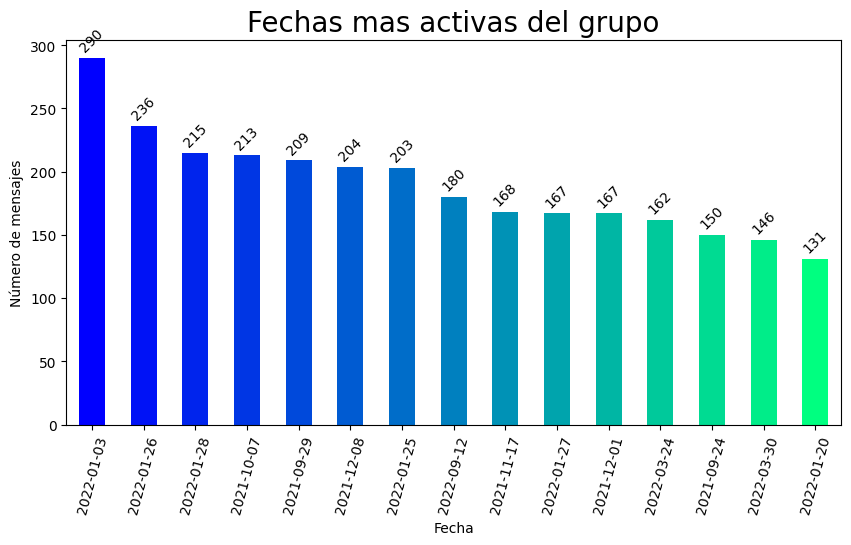

In [ ]:
#df['Fecha'] = df['Fecha'].dt.date
fecha_df = df['Fecha'].value_counts()

color = plt.cm.winter(np.linspace(0, 1, 15))
plt.rcParams['figure.figsize'] = (10,5)
plt.title('Fechas mas activas del grupo', fontsize=20)

plt.xlabel('Fecha')
plt.ylabel('Número de mensajes')



fecha_df = fecha_df.head(15)
fecha_df.plot.bar(color =color,figsize = (10,5))

for i,value in enumerate(fecha_df):
  plt.text(i, value + 5, str(value), ha='center',rotation=45)

plt.xticks(rotation=75)
plt.show()



##Horas más activas

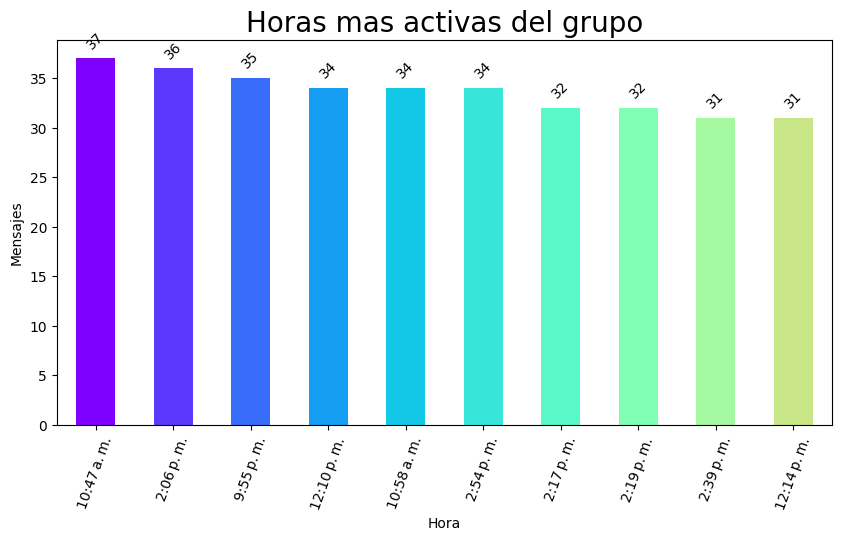

In [ ]:
horas_df = df['Hora'].value_counts()
horas_df = horas_df.head(10)
color = plt.cm.rainbow(np.linspace(0, 1, 15))
plt.rcParams['figure.figsize'] = (10,5)
plt.title('Horas mas activas del grupo', fontsize=20)

plt.xlabel('Hora')
plt.ylabel('Mensajes')

for i,value in enumerate(horas_df):
  plt.text(i, value + 1 , str(value), ha='center',rotation=45)

horas_df.plot.bar(color = color)

plt.xticks(rotation=70)
plt.show()

#Palabras mas usadas

In [ ]:
#Fecha de TSU
tsu = (mensajes_df['Fecha'] > dt.date(2021,1,1)) & (mensajes_df['Fecha'] < dt.date(2022,4,30))
#Fecha de Ing
ing = (mensajes_df['Fecha'] > dt.date(2022,9,1)) & (mensajes_df['Fecha'] < dt.date(2023,12,31))
#anio_2023 = (mensajes_df['Fecha'] > dt.date(2023,1,1)) & (mensajes_df['Fecha'] < dt.date(2023,12,31))
#mensajes=mensajes_df[tsu]
#mensajes[:50]

In [ ]:
# Crear un string que contendrá todas las palabras
total_palabras = ' '
stopwords = STOPWORDS.update([
    'que', 'qué', 'con', 'de', 'te', 'en', 'la', 'lo', 'le', 'el', 'las', 'los', 'les', 'por', 'es',
    'son', 'se', 'para', 'un', 'una', 'chicos', 'su', 'si', 'chic', 'nos', 'ya', 'hay', 'esta',
    'pero', 'del', 'mas', 'más', 'eso', 'este', 'como', 'así', 'todo', 'https', 'tu', 'y', 'al',
    'mi', 'tus', 'esa', 'o', 'sus', 'tiene', 'también', 'tambien', 'sea', 'esos', 'esto', 'ese',
    'uno', 'ahi', 'ahí', 'va', 'está', 'yo', 'tenga', 'ser', 'otra', 'otro', 'mis', 'han',
    'jajaja','jajajaja','haz','xd','jaja','pa','dijo'
    ])



#Palabras mas usadas en TSU

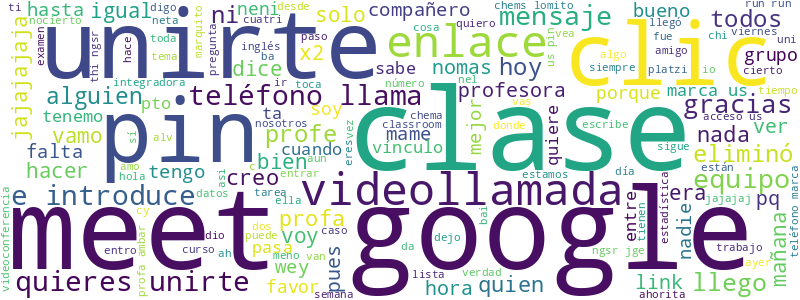

In [ ]:
mensajes=mensajes_df[tsu]
for mensaje in mensajes['Mensaje'].values:
  palabras = str(mensaje).lower().split() # Obtener las palabras de cada línea del txt
  for palabra in palabras:
    total_palabras = total_palabras + palabra + ' ' # Acumular todas las palabras

wordcloud = WordCloud(width = 800, height = 300,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(total_palabras)
wordcloud.to_image()

#Palabras más usadas en Ing

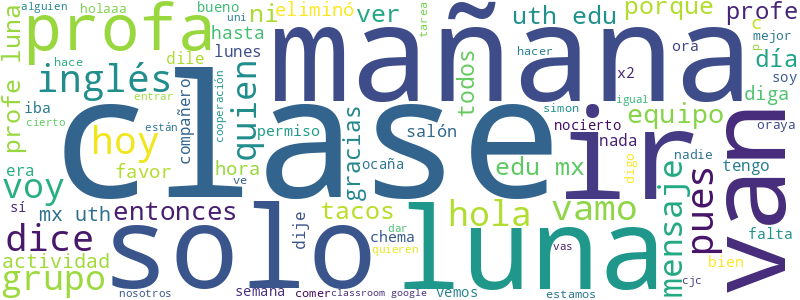

In [ ]:
mensajes=mensajes_df[ing]
total_palabras = ' '
for mensaje in mensajes['Mensaje'].values:
  palabras = str(mensaje).lower().split() # Obtener las palabras de cada línea del txt
  for palabra in palabras:
    total_palabras = total_palabras + palabra + ' ' # Acumular todas las palabras

img = WordCloud(width = 800, height = 300,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(total_palabras)
img.to_image()